# Homework 04 - Validation

In [2]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## Preparing the Dataset

In [6]:
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
response = requests.get(url)
outer_zip = zipfile.ZipFile(io.BytesIO(response.content))
print(outer_zip.namelist()) 
with outer_zip.open('bank.zip') as inner_zip_file:
    inner_zip = zipfile.ZipFile(inner_zip_file)
    
    with inner_zip.open('bank-full.csv') as csvfile:
        df = pd.read_csv(csvfile, sep=';')
df.head()
# transform columns to snake case
df.columns = df.columns.str.lower().str.replace(' ', '_')

# transform string data to snake case
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

base = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

df = df[base]

['bank.zip', 'bank-additional.zip']


In [8]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [10]:
X = df.drop(columns=['y'])
y = df['y'].map({'yes': 1, 'no': 0})
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

len(X_train), len(X_val), len(X_test)

(27126, 9042, 9043)

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous


In [11]:
numeric = ['balance', 'day', 'duration', 'previous']
auc_values = {}

for col in numeric:
    auc = roc_auc_score(y_train, X_train[col])

    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])

    auc_values[col] = auc

print("AUC values:")
for col, auc in auc_values.items():
    print(f"{col}: {auc:.3f}")

best_variable = max(auc_values, key=auc_values.get)
print(f"The numerical variable with the highest AUC is: {best_variable} with AUC = {auc_values[best_variable]:.3f}")


AUC values:
balance: 0.592
day: 0.529
duration: 0.813
previous: 0.599
The numerical variable with the highest AUC is: duration with AUC = 0.813


## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.69
- 0.79
- 0.89
- 0.99

In [12]:
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')

pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
])

pipeline.fit(X_train_dict, y_train)

y_pred_proba = pipeline.predict_proba(X_val_dict)[:, 1]
auc = roc_auc_score(y_val, y_pred_proba)

print(f'AUC: {auc:.3f}')

AUC: 0.901


## Question 3: Precision and Recall

Now let's compute precision and recall for our model.
- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?
- 0.265
- 0.465
- 0.665
- 0.865

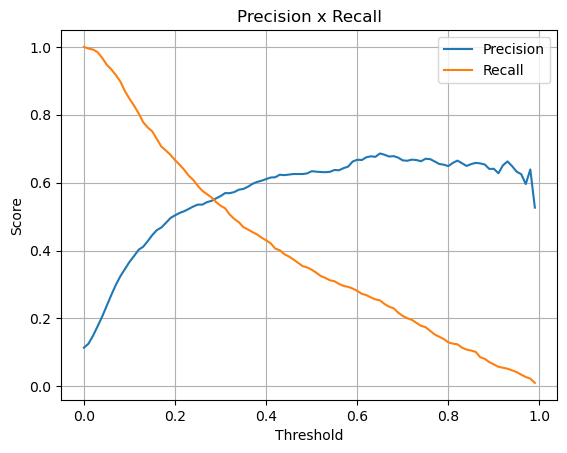

In [13]:
# precision, recall and thresholds
precisions = []
recalls = []
thresholds = np.arange(0.0, 1.0, 0.01)

# iterate over thresholds
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)

    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    precisions.append(precision)
    recalls.append(recall)

# plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')

plt.title('Precision x Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$
F1 = 2 \times \frac{{\text{{P}} \times \text{{R}}}} {{\text{{P}} + \text{{R}}}}
$$

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?
- 0.02
- 0.22
- 0.42
- 0.62

Max F1 Score: 0.5741 at threshold: 0.190


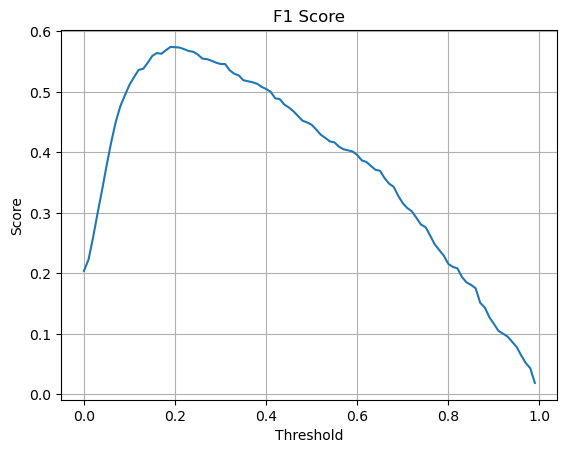

In [14]:
# F1 Score and thresholds
f1s = []
thresholds = np.arange(0.0, 1.0, 0.01)

# iterate over thresholds
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)

    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    f1s.append(f1)

max_f1 = np.argmax(f1s)
best_threshold = thresholds[max_f1]
best_f1_score = f1s[max_f1]
print(f'Max F1 Score: {best_f1_score:.4f} at threshold: {best_threshold:.3f}')

# plot precision and recall curves
plt.plot(thresholds, f1s, label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True)
plt.show()

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?
- 0.0001
- 0.006
- 0.06
- 0.26

In [17]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    pipeline = Pipeline([
        ('vectorizer', DictVectorizer(sparse=False)),
        ('model', LogisticRegression(solver='liblinear', C=1.0, max_iter=1000))
    ])
    
    pipeline.fit(X_train.to_dict(orient='records'), y_train)
    
    y_pred_proba = pipeline.predict_proba(X_val.to_dict(orient='records'))[:, 1]
    
    auc = roc_auc_score(y_val, y_pred_proba)
    auc_scores.append(auc)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print("AUC scores for each fold:", auc_scores)
print(f"Standard deviation of AUC scores: {std_auc:.3f}")


AUC scores for each fold: [0.906356633482869, 0.8988020834328037, 0.9052085464436155, 0.9123581915248582, 0.906269850170676]
Standard deviation of AUC scores: 0.004


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [18]:
C_values = [0.000001, 0.001, 1]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_results = {}

for C in C_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline = Pipeline([
            ('vectorizer', DictVectorizer(sparse=False)),
            ('model', LogisticRegression(solver='liblinear', C=C, max_iter=1000))
        ])
        
        pipeline.fit(X_train.to_dict(orient='records'), y_train)
        
        y_pred_proba = pipeline.predict_proba(X_val.to_dict(orient='records'))[:, 1]
        
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    auc_results[C] = {'mean_auc': round(mean_auc, 3), 'std_auc': round(std_auc, 3)}

for C, result in auc_results.items():
    print(f"C={C}: Mean AUC = {result['mean_auc']}, Std AUC = {result['std_auc']}")

best_C = min(auc_results.keys(), key=lambda C: (-auc_results[C]['mean_auc'], auc_results[C]['std_auc']))

print(f"Best C: {best_C}")


C=1e-06: Mean AUC = 0.705, Std AUC = 0.011
C=0.001: Mean AUC = 0.868, Std AUC = 0.007
C=1: Mean AUC = 0.906, Std AUC = 0.004
Best C: 1
